In [1]:
import os
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchmetrics import F1Score,FBetaScore
import random
from timeit import default_timer as timer

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = Path("data/")
data_path.mkdir(parents=True,exist_ok=True)

In [3]:
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df = pd.DataFrame(image_list)

In [4]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,Full Water level
1,data\Full Water level\Full Water level\01-wa...,Full Water level
2,data\Full Water level\Full Water level\0bnC0...,Full Water level
3,data\Full Water level\Full Water level\1-0l-...,Full Water level
4,data\Full Water level\Full Water level\1000_...,Full Water level


In [5]:
df.shape

(429, 2)

In [6]:
df.classes.value_counts()

Full  Water level    255
Half water level     135
Overflowing           39
Name: classes, dtype: int64

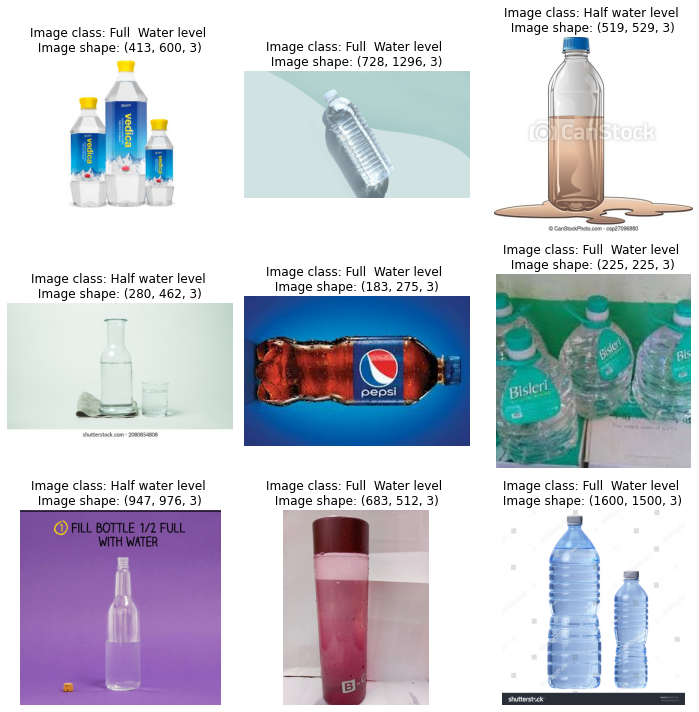

In [7]:
def plot_image(data):

    rnd_sample = df.sample(9)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, path in zip(axes, rnd_sample["path"]):
        img_class = rnd_sample[rnd_sample["path"] == path]["classes"].iloc[0]

        img = Image.open(path)
        img_as_array = np.array(img)
        ax.imshow(img_as_array)
        ax.set_title(f"Image class: {img_class} \n Image shape: {img_as_array.shape} ")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_image(df)


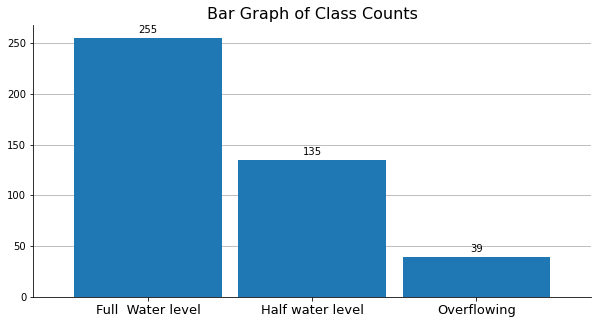

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Bar Graph of Class Counts", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")


#### We have imbalanced label.

In [9]:
df["classes"] = df["classes"].map(
    {
        "Full  Water level": "full",
        "Half water level": "half",
        "Overflowing": "overflowing",
    }
)


In [10]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,full
1,data\Full Water level\Full Water level\01-wa...,full
2,data\Full Water level\Full Water level\0bnC0...,full
3,data\Full Water level\Full Water level\1-0l-...,full
4,data\Full Water level\Full Water level\1000_...,full


In [11]:
from sklearn.model_selection import train_test_split


train_df,test_df = train_test_split(df,test_size=0.2,shuffle=True,random_state=42)

In [12]:
train_df.shape,test_df.shape

((343, 2), (86, 2))

In [13]:
def find_classes(data):
    # Get the class names by scanning the target directory
    classes = ["full", "half", "overflowing"]
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx


In [14]:
find_classes(df)

(['full', 'half', 'overflowing'], {'full': 0, 'half': 1, 'overflowing': 2})

In [15]:
class CustomImageFolder(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(data)
        self.targets = data.classes.values

    def __len__(self):
        return len(self.data)

    def load_image(self, idx: int) -> Image.Image:
        image_path = self.data.iloc[idx, 0]
        return Image.open(image_path)

    def __getitem__(self, idx):

        img = self.load_image(idx)

        class_name = self.data.iloc[idx, 1]
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img), class_idx

        else:
            return img, class_idx


In [16]:
from torchvision import datasets

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.TrivialAugmentWide(),
    #transforms.ColorJitter(brightness=.5, hue=.3),
    #transforms.RandomRotation(degrees=(0, 180)),
    transforms.AutoAugment(),
    
    #transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
    #transforms.AutoAugment(),
    transforms.ToTensor()
    
])
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
])


In [18]:
train_data_transformed = CustomImageFolder(train_df, transform=train_transform)
test_data_transformed = CustomImageFolder(test_df, transform=test_transform)

In [19]:
class_names=train_data_transformed.classes

### Random image in train dataset

In [20]:
def visualize_random_images(data, classes, num_images=3):
    random_samples_idx = random.sample(range(len(data)), k=num_images)
    plt.figure(figsize=(10, 10))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = (
            data[targ_sample][0],
            data[targ_sample][1],
        )
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")

        title = f"class: {classes[targ_label]}"

        title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

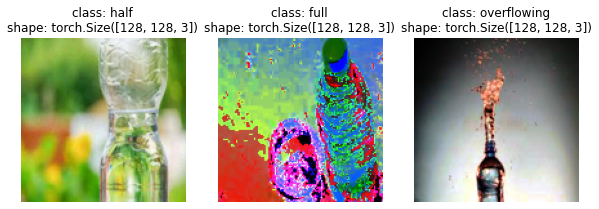

In [21]:
visualize_random_images(train_data_transformed,class_names)

### Random image in test dataset

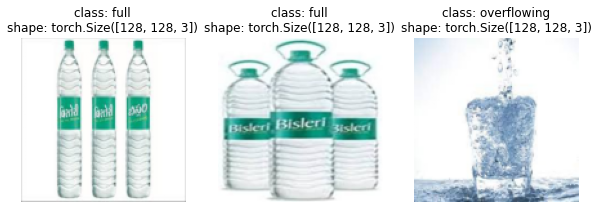

In [22]:
visualize_random_images(test_data_transformed,class_names)

In [23]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data_transformed, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data_transformed, batch_size=BATCH_SIZE, shuffle=False)


In [24]:
img_batch, label_batch = next(iter(train_dataloader))
print(f"Image Shape: {img_batch.shape} -> [batch_size,color_channels,height,width]")
print(f"Label shape: {label_batch.shape}")


Image Shape: torch.Size([32, 3, 128, 128]) -> [batch_size,color_channels,height,width]
Label shape: torch.Size([32])


## Creating Baseline Model

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
import torch
from torch import nn
from torchinfo import summary

In [27]:
from torchinfo import summary

In [30]:
class WaterBottleModel(nn.Module):
    def __init__(self,input_shape:int,output_shape:int,hidden_units:int):
        super().__init__()
        self.layer_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=2,padding=2),
            nn.BatchNorm2d(hidden_units),
            #nn.Dropout(),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=2,padding=2),
            nn.BatchNorm2d(hidden_units),
            #nn.Dropout(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=128,kernel_size=2,padding=2),
            nn.BatchNorm2d(128),
            #nn.Dropout(),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=2,padding=2),
            nn.BatchNorm2d(128),
            #nn.Dropout(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=2),
            nn.BatchNorm2d(128),
            #nn.Dropout(0.25),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=hidden_units,kernel_size=3,padding=2),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3))
        self.layer_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=4,padding=2),
            nn.BatchNorm2d(hidden_units),
            #nn.Dropout(),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=4,padding=2),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3))
        
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1600,out_features=output_shape)

        )

    def forward(self,x):
        
        return  self.clf(self.layer_block_4(self.layer_block_3(self.layer_block_2(self.layer_block_1(x)))))
        #return self.clf(self.layer_block_1(x))
torch.manual_seed(42)
model = WaterBottleModel(input_shape=3,output_shape=3,hidden_units=64).to(device) 


In [31]:
summary(model, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
WaterBottleModel                         [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 67, 67]          --
│    └─Conv2d: 2-1                       [32, 64, 131, 131]        832
│    └─BatchNorm2d: 2-2                  [32, 64, 131, 131]        128
│    └─ReLU: 2-3                         [32, 64, 131, 131]        --
│    └─Conv2d: 2-4                       [32, 64, 134, 134]        16,448
│    └─BatchNorm2d: 2-5                  [32, 64, 134, 134]        128
│    └─ReLU: 2-6                         [32, 64, 134, 134]        --
│    └─MaxPool2d: 2-7                    [32, 64, 67, 67]          --
├─Sequential: 1-2                        [32, 128, 36, 36]         --
│    └─Conv2d: 2-8                       [32, 128, 70, 70]         32,896
│    └─BatchNorm2d: 2-9                  [32, 128, 70, 70]         256
│    └─ReLU: 2-10                        [32, 128, 70, 70]         --
│  

In [32]:
from sklearn.utils.class_weight import compute_class_weight

In [33]:
class_weights=compute_class_weight(class_weight="balanced",classes=train_data_transformed.classes,y=train_data_transformed.targets)
class_weights=torch.tensor(class_weights,dtype=torch.float,device=device)

In [34]:
#class_weights tensor([0.5688, 1.0208, 3.8111], device='cuda:0')

In [35]:
class_weights

tensor([0.5688, 1.0208, 3.8111], device='cuda:0')

In [36]:
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
fbeta_score = FBetaScore(task="multiclass",num_classes=len(train_data_transformed.classes),beta=0.5).to(device)
f1_score = F1Score(task="multiclass",num_classes=len(train_data_transformed.classes),average="macro").to(device)

In [37]:
from sklearn.metrics import classification_report

In [38]:
def train_step(model,dataloader,loss_fn,optimizer,fbeta_score,f1_score,device):
    
    model.train()
    train_loss,train_fbeta_score,train_f1_score=0,0,0

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        train_fbeta_score += fbeta_score(y_pred,y)
        train_f1_score += f1_score(y_pred,y)
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(dataloader)
    train_fbeta_score /= len(dataloader)
    train_f1_score /= len(dataloader)

    return train_loss,train_fbeta_score,train_f1_score

In [39]:
def test_step(model,dataloader,loss_fn,fbeta_score,f1_score,device):
    model.eval()
    test_loss, test_fbeta_score,test_f1_score =0,0,0
    
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss
            test_fbeta_score += fbeta_score(y_pred,y)
            test_f1_score += f1_score(y_pred,y)
            
            
        test_loss /= len(dataloader)
        test_fbeta_score /= len(dataloader)
        test_f1_score /= len(dataloader)
        

    return test_loss,test_fbeta_score,test_f1_score

In [40]:
from tqdm.auto import tqdm

In [41]:
def train(model,train_dataloader,test_dataloader,loss_fn,optimizer,epochs,device):
    results= {"train_loss": [],
            "train_fbeta_score":[],
            "train_f1_score":[],
            "test_loss":[],
            "test_fbeta_score":[],
            "test_f1_score":[]}

    for epoch in tqdm(range(epochs)):

        train_loss,train_fbeta_score,train_f1_score = train_step(model,train_dataloader,loss_fn,optimizer,fbeta_score,f1_score,device)
        test_loss,test_fbeta_score,test_f1_score= test_step(model,test_dataloader,loss_fn,fbeta_score,f1_score,device)
        scheduler.step()

        if epoch % 4 == 0:

            print(
            f"Epoch: {epoch}--> lr: {scheduler.get_last_lr()[0]}\n "  
            f"train_loss: {train_loss:.4f} | "
            f"train_f0.5_score: {np.round(train_fbeta_score.item(),4)*100}% | "
            f"train_f1_score: {np.round(train_f1_score.item(),4)*100}% | \n "
            f"test_loss: {test_loss:.4f} | "
            f"test_fbeta_score: {np.round(test_fbeta_score.item(),2)*100}% | "
            f"test_f1_score: {np.round(test_f1_score.item(),2)*100}%"
            )

        
        results["train_loss"].append(train_loss.cpu().detach().numpy())
        results["train_fbeta_score"].append(train_fbeta_score.cpu().detach().numpy())
        results["train_f1_score"].append(train_f1_score.cpu().detach().numpy())
        results["test_loss"].append(test_loss.cpu().detach().numpy())
        results["test_fbeta_score"].append(test_fbeta_score.cpu().detach().numpy())
        results["test_f1_score"].append(test_f1_score.cpu().detach().numpy())

    
    return results

In [42]:
# Train model_0 
torch.manual_seed(42)
start_time = timer()
NUM_EPOCHS = 64
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print("Train time: ", (end_time - start_time) / 60, "minutes")

  2%|▏         | 1/64 [00:53<56:23, 53.70s/it]

Epoch: 0--> lr: 9e-05
 train_loss: 1.1634 | train_f0.5_score: 44.97% | train_f1_score: 32.15% | 
 test_loss: 1.1052 | test_fbeta_score: 26.0% | test_f1_score: 14.000000000000002%


  8%|▊         | 5/64 [04:19<50:24, 51.26s/it]

Epoch: 4--> lr: 5.904900000000002e-05
 train_loss: 0.9040 | train_f0.5_score: 61.56% | train_f1_score: 53.68000000000001% | 
 test_loss: 0.9602 | test_fbeta_score: 51.0% | test_f1_score: 49.0%


 14%|█▍        | 9/64 [07:43<47:00, 51.28s/it]

Epoch: 8--> lr: 3.874204890000002e-05
 train_loss: 0.7341 | train_f0.5_score: 68.89% | train_f1_score: 62.839999999999996% | 
 test_loss: 0.8758 | test_fbeta_score: 69.0% | test_f1_score: 62.0%


 20%|██        | 13/64 [11:12<44:02, 51.82s/it]

Epoch: 12--> lr: 2.5418658283290016e-05
 train_loss: 0.7396 | train_f0.5_score: 69.85% | train_f1_score: 64.12% | 
 test_loss: 0.8127 | test_fbeta_score: 68.0% | test_f1_score: 62.0%


 27%|██▋       | 17/64 [14:43<41:11, 52.59s/it]

Epoch: 16--> lr: 1.667718169966658e-05
 train_loss: 0.6622 | train_f0.5_score: 73.94% | train_f1_score: 67.24% | 
 test_loss: 0.7923 | test_fbeta_score: 69.0% | test_f1_score: 62.0%


 33%|███▎      | 21/64 [18:08<36:46, 51.32s/it]

Epoch: 20--> lr: 1.0941898913151244e-05
 train_loss: 0.6273 | train_f0.5_score: 74.83999999999999% | train_f1_score: 68.46% | 
 test_loss: 0.7917 | test_fbeta_score: 72.0% | test_f1_score: 66.0%


 39%|███▉      | 25/64 [21:31<32:58, 50.73s/it]

Epoch: 24--> lr: 7.1789798769185315e-06
 train_loss: 0.6148 | train_f0.5_score: 76.32% | train_f1_score: 69.59% | 
 test_loss: 0.7850 | test_fbeta_score: 74.0% | test_f1_score: 68.0%


 45%|████▌     | 29/64 [24:53<29:30, 50.59s/it]

Epoch: 28--> lr: 4.710128697246249e-06
 train_loss: 0.6576 | train_f0.5_score: 74.46000000000001% | train_f1_score: 65.72% | 
 test_loss: 0.7760 | test_fbeta_score: 73.0% | test_f1_score: 67.0%


 52%|█████▏    | 33/64 [28:16<26:05, 50.50s/it]

Epoch: 32--> lr: 3.090315438263264e-06
 train_loss: 0.6220 | train_f0.5_score: 80.01% | train_f1_score: 74.6% | 
 test_loss: 0.7814 | test_fbeta_score: 72.0% | test_f1_score: 65.0%


 58%|█████▊    | 37/64 [31:38<22:46, 50.59s/it]

Epoch: 36--> lr: 2.0275559590445276e-06
 train_loss: 0.6172 | train_f0.5_score: 76.83% | train_f1_score: 68.94% | 
 test_loss: 0.7839 | test_fbeta_score: 71.0% | test_f1_score: 63.0%


 64%|██████▍   | 41/64 [35:02<19:28, 50.80s/it]

Epoch: 40--> lr: 1.3302794647291146e-06
 train_loss: 0.5722 | train_f0.5_score: 80.69% | train_f1_score: 79.67% | 
 test_loss: 0.7824 | test_fbeta_score: 72.0% | test_f1_score: 65.0%


 70%|███████   | 45/64 [38:24<16:00, 50.57s/it]

Epoch: 44--> lr: 8.727963568087721e-07
 train_loss: 0.6080 | train_f0.5_score: 77.92% | train_f1_score: 74.0% | 
 test_loss: 0.7761 | test_fbeta_score: 73.0% | test_f1_score: 66.0%


 77%|███████▋  | 49/64 [41:45<12:34, 50.31s/it]

Epoch: 48--> lr: 5.726416897022355e-07
 train_loss: 0.5628 | train_f0.5_score: 76.95% | train_f1_score: 71.43% | 
 test_loss: 0.7826 | test_fbeta_score: 71.0% | test_f1_score: 64.0%


 83%|████████▎ | 53/64 [45:08<09:16, 50.58s/it]

Epoch: 52--> lr: 3.7571021261363677e-07
 train_loss: 0.5716 | train_f0.5_score: 78.99000000000001% | train_f1_score: 73.66% | 
 test_loss: 0.7813 | test_fbeta_score: 71.0% | test_f1_score: 63.0%


 89%|████████▉ | 57/64 [48:28<05:51, 50.17s/it]

Epoch: 56--> lr: 2.465034704958071e-07
 train_loss: 0.6336 | train_f0.5_score: 75.3% | train_f1_score: 71.57% | 
 test_loss: 0.7813 | test_fbeta_score: 73.0% | test_f1_score: 66.0%


 95%|█████████▌| 61/64 [51:51<02:31, 50.50s/it]

Epoch: 60--> lr: 1.6173092699229905e-07
 train_loss: 0.6226 | train_f0.5_score: 79.84% | train_f1_score: 72.74000000000001% | 
 test_loss: 0.7853 | test_fbeta_score: 73.0% | test_f1_score: 65.0%


100%|██████████| 64/64 [54:22<00:00, 50.98s/it]

Train time:  54.381888966666665 minutes


In [43]:
def plot_curves(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_acc = results["train_fbeta_score"]
    test_acc = results["test_fbeta_score"]
    train_f1_score = results["train_f1_score"]
    test_f1_score = results["test_f1_score"]
    epochs = range(len(train_loss))

    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    fig.suptitle("Comparison of Training and Testing Metrics Over Epochs", fontsize=16)

    metric_names = [("loss", "Loss"), ("fbeta_score", "f0.5"), ("f1_score", "F1 Score")]
    for ax, (metric, label) in zip(axes, metric_names):
        ax.plot(epochs, results[f"train_{metric}"], label=f"train {label}")
        ax.plot(epochs, results[f"test_{metric}"], label=f"test {label}")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(which="both", axis="y")
        ax.set_axisbelow(True)
        ax.set_xlabel("Epochs")
        ax.set_title(label)
        ax.legend()

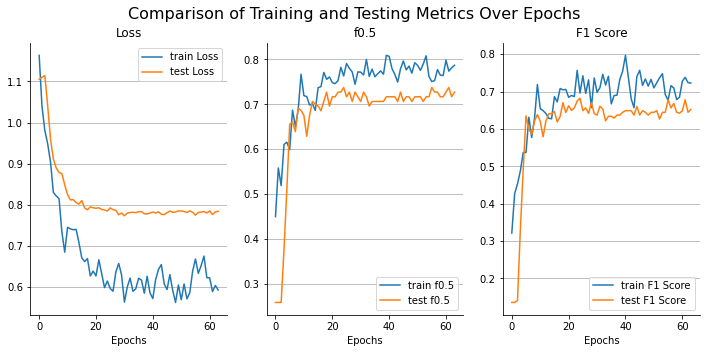

In [44]:
plot_curves(model_results)

In [45]:
from tqdm.auto import tqdm
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


In [46]:
targets=test_data_transformed.targets
mapping = {'full': 0, 'half': 1, 'overflowing': 2}
targets = np.array([mapping[i] for i in targets])

In [47]:
clf_report = classification_report(targets, y_pred_tensor.cpu().numpy(), 
        target_names=train_data_transformed.classes)
print(clf_report)

              precision    recall  f1-score   support

        full       0.91      0.76      0.83        54
        half       0.59      0.70      0.64        23
 overflowing       0.43      0.67      0.52         9

    accuracy                           0.73        86
   macro avg       0.64      0.71      0.66        86
weighted avg       0.78      0.73      0.75        86



Text(0.5, 1.0, 'Confusion Matrix')

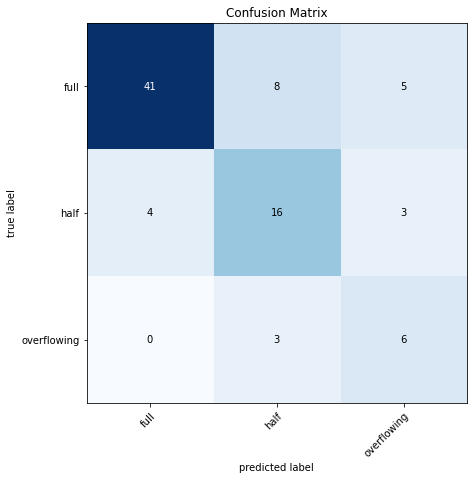

In [48]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix


confmat = ConfusionMatrix(num_classes=len(train_data_transformed.classes), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,target=torch.from_numpy(targets).type(torch.float)
                         )

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data_transformed.classes, #
    figsize=(10, 7))
ax.set_title("Confusion Matrix")

In [49]:
import random
#random.seed(41)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data_transformed), k=9):
    test_samples.append(sample)
    test_labels.append(label)


print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 128, 128])
Test sample label: 0 (full)


In [50]:
def sample_predict(model,data,device):

  y_pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in tqdm(test_samples):
      sample = torch.unsqueeze(sample, dim=0).to(device)
    
      y_logit = model(X)
      y_pred = torch.softmax(y_logit.squeeze(), dim=1).argmax(dim=1)
      y_pred_probs.append(y_pred.cpu())
  return torch.cat(y_pred_probs)

In [51]:
pred_probs= sample_predict(model,test_samples,device)

100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


In [52]:
pred_classes = pred_probs

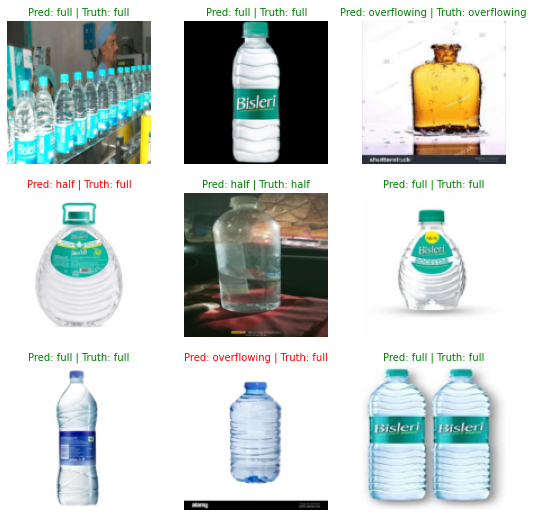

In [53]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.permute(1, 2, 0))
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    color = 'g' if pred_label == truth_label else 'r'
    plt.title(f'Pred: {pred_label} | Truth: {truth_label}', fontsize=10, c=color)
    plt.axis(False)